--- 🚀 Publication-Level Ablation Study (Device: mps) ---
开始多维度消融实验...
👉 Testing Ours (Trans-VAE)...
👉 Testing Baseline (LSTM)...
👉 Testing w/o Pos. Enc....
👉 Testing w/o VAE (Det. AE)...

生成图表...
✅ 图表已保存: /Users/oushilin/Desktop/Infor 301/final/Publication_Ablation/Publication_Ablation_Matrix.png

=== LaTeX Table Data (Copy to your paper) ===
Model                & MSE (Error)  & Smoothness   & Diversity    \\
\hline
Ours (Trans-VAE)     & 0.0657       & 0.0344       & 2.8263       \\
Baseline (LSTM)      & 0.0685       & 0.0372       & 0.3901       \\
w/o Pos. Enc.        & 0.0812       & 0.0345       & 0.7840       \\
w/o VAE (Det. AE)    & 0.1021       & 0.0315       & 1.2040       \\


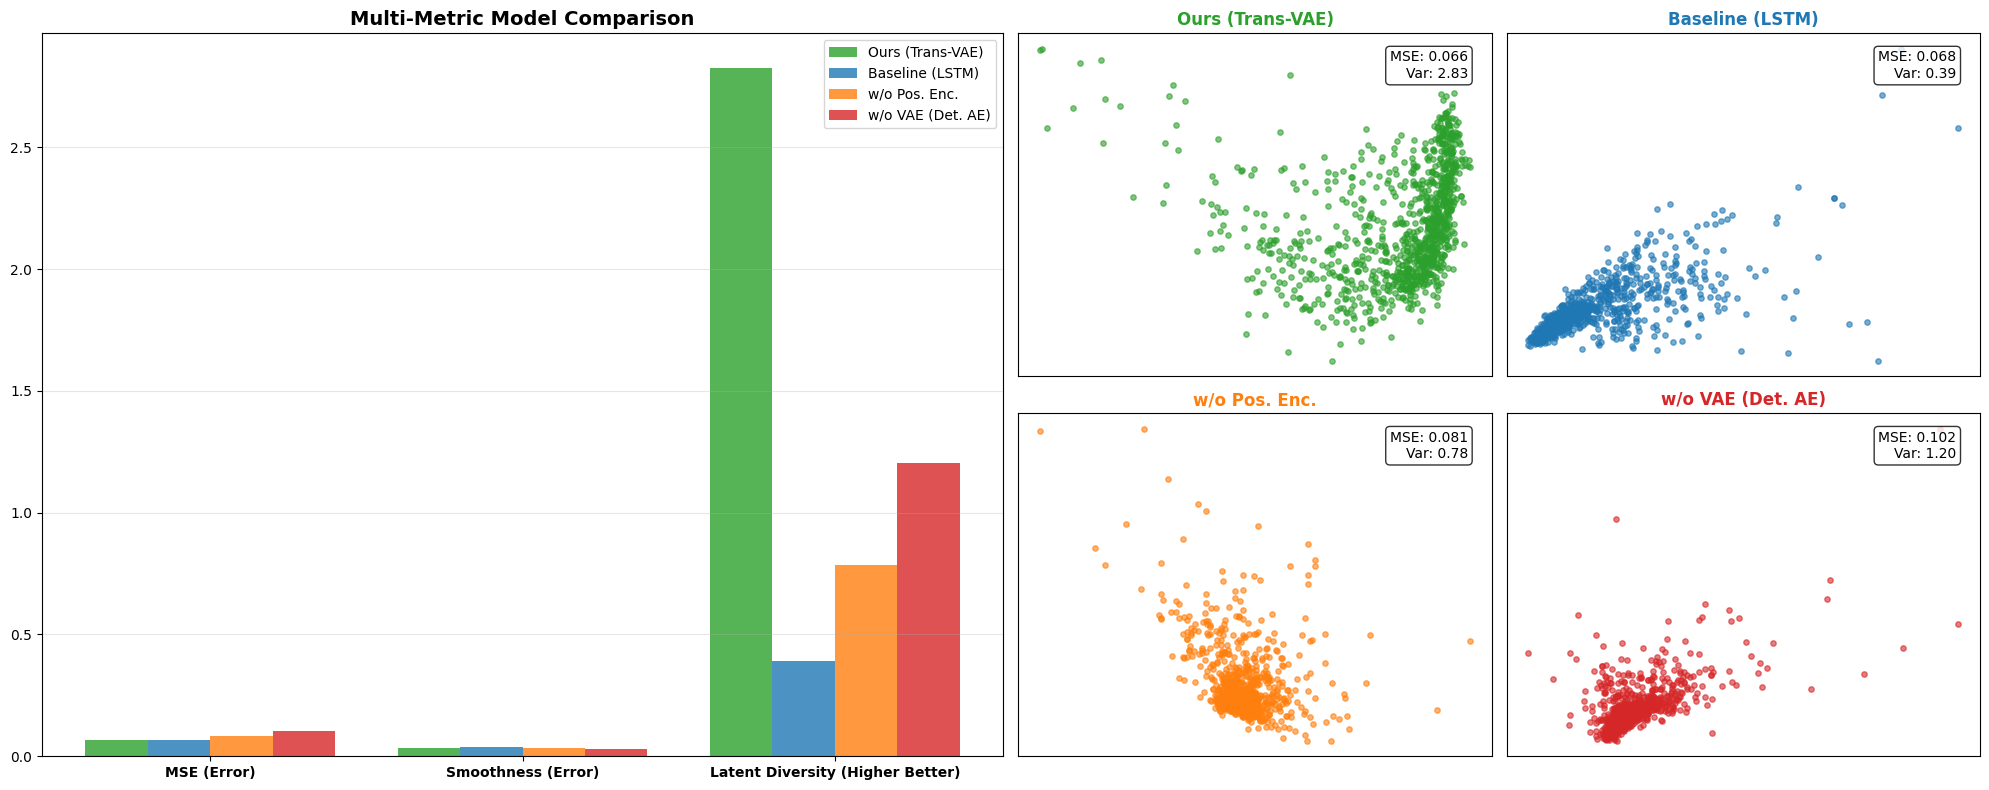

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = '/Users/oushilin/Desktop/Infor 301/final/Processed_Urban_Dataset.pt'
SAVE_DIR = os.path.expanduser("~/Desktop/Infor 301/final/Publication_Ablation/")

if not os.path.exists(SAVE_DIR): os.makedirs(SAVE_DIR)

print(f"--- 🚀 Publication-Level Ablation Study (Device: {DEVICE}) ---")


class BaseEvolutionModel(nn.Module):
    def __init__(self, node_features, periods, latent_dim=32):
        super().__init__()
        self.node_features = node_features
        self.periods = periods
        self.latent_dim = latent_dim

# --- Model 1: Our Full Transformer-VAE ---
class FullTransformerVAE(BaseEvolutionModel):
    def __init__(self, node_features, periods, d_model=64, use_pos_enc=True):
        super().__init__(node_features, periods)
        self.use_pos_enc = use_pos_enc
        self.embedding = nn.Sequential(nn.Linear(node_features, d_model), nn.GELU())
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model) * 0.1)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=128, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
        self.fc_mu = nn.Linear(d_model, self.latent_dim)
        self.fc_logvar = nn.Linear(d_model, self.latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128), nn.GELU(),
            nn.Linear(128, node_features * periods)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.permute(0, 2, 1) # [B, F, T] -> [B, T, F]
        h = self.embedding(x)
        if self.use_pos_enc:
            h = h + self.pos_encoder
        h = self.transformer(h) 
        h_avg = torch.mean(h, dim=1)
        mu, logvar = self.fc_mu(h_avg), self.fc_logvar(h_avg)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z).reshape(-1, self.node_features, self.periods)
        return recon, mu, logvar

# --- Model 2: LSTM-VAE (Strong Baseline) ---

class LSTM_VAE(BaseEvolutionModel):
    def __init__(self, node_features, periods, hidden_dim=64):
        super().__init__(node_features, periods)
        self.lstm = nn.LSTM(input_size=node_features, hidden_size=hidden_dim, 
                            num_layers=2, batch_first=True, bidirectional=False)
        
        self.fc_mu = nn.Linear(hidden_dim, self.latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, self.latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128), nn.GELU(),
            nn.Linear(128, node_features * periods)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.permute(0, 2, 1) # [B, T, F]
        # LSTM output: (batch, seq, hidden)
        output, (h_n, c_n) = self.lstm(x)
        h_last = output[:, -1, :]
        
        mu, logvar = self.fc_mu(h_last), self.fc_logvar(h_last)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z).reshape(-1, self.node_features, self.periods)
        return recon, mu, logvar

# --- Model 3: Deterministic AE (Ablation) ---
class DeterministicAE(BaseEvolutionModel):
    def __init__(self, node_features, periods, d_model=64):
        super().__init__(node_features, periods)
        self.embedding = nn.Sequential(nn.Linear(node_features, d_model), nn.GELU())
        self.pos_encoder = nn.Parameter(torch.randn(1, periods, d_model) * 0.1)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc_z = nn.Linear(d_model, self.latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128), nn.GELU(),
            nn.Linear(128, node_features * periods)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        h = self.embedding(x) + self.pos_encoder
        h = self.transformer(h)
        h_avg = torch.mean(h, dim=1)
        z = self.fc_z(h_avg)
        recon = self.decoder(z).reshape(-1, self.node_features, self.periods)
        return recon, z, torch.zeros_like(z)


def add_noise_and_mask(x, noise_level=0.15, mask_prob=0.15):
    noisy_x = x + torch.randn_like(x) * noise_level
    mask = torch.rand(x.size(0), 1, x.size(2)).to(x.device) > mask_prob
    noisy_x = noisy_x * mask.float()
    return noisy_x

def train_engine(model, loader, epochs=80, is_vae=True):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    model.to(DEVICE)
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        batch_loss = 0
        valid_batches = 0
        for clean_x, _ in loader:
            clean_x = clean_x.to(DEVICE)
            noisy_input = add_noise_and_mask(clean_x)
            
            optimizer.zero_grad()
            recon, mu, logvar = model(noisy_input)
            
            recon_loss = F.mse_loss(recon, clean_x)
            
            total_loss = recon_loss
            if is_vae:
                logvar = torch.clamp(logvar, min=-10, max=10)
                kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                total_loss += 0.005 * kld 
            if torch.isnan(total_loss) or torch.isinf(total_loss): continue
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_loss += total_loss.item()
            valid_batches += 1
        loss_history.append(batch_loss / max(valid_batches, 1))
    return loss_history

def calculate_metrics(model, full_x):
    model.eval()
    clean_input = full_x.to(DEVICE)
    noisy_test = add_noise_and_mask(clean_input, noise_level=0.2, mask_prob=0.2)
    
    with torch.no_grad():
        recon, mu, _ = model(noisy_test)

        mse = F.mse_loss(recon, clean_input).item()
        
     
        idx = np.random.choice(len(mu), min(1000, len(mu)), replace=False)
        mu_np = mu[idx].cpu().numpy()

        latent_variance = np.var(mu_np)

        recon_diff = recon[:, :, 1:] - recon[:, :, :-1]
        smoothness_loss = torch.mean(torch.abs(recon_diff)).item()
        
    return mse, latent_variance, smoothness_loss, mu.cpu().numpy()


def run_publication_ablation():
    # Load Data
    if not os.path.exists(DATA_PATH): return
    try:
        db = torch.load(DATA_PATH)
    except: return
    
    all_x = []
    for name, data in db.items():
        feat = data["features"].permute(1, 2, 0)
        feat = torch.nan_to_num(feat, nan=0.0)
        feat = (feat - feat.mean()) / (feat.std() + 1e-7)
        all_x.append(feat)
    full_x = torch.cat(all_x, dim=0) 
    loader = DataLoader(TensorDataset(full_x, torch.zeros(full_x.size(0))), batch_size=256, shuffle=True)
    
 
    models = {
        "Ours (Trans-VAE)": FullTransformerVAE(7, 10, use_pos_enc=True),
        "Baseline (LSTM)": LSTM_VAE(7, 10),
        "w/o Pos. Enc.": FullTransformerVAE(7, 10, use_pos_enc=False),
        "w/o VAE (Det. AE)": DeterministicAE(7, 10)
    }
    
    results = {}
    
    print("开始多维度消融实验...")
    
    for name, model in models.items():
        print(f"👉 Testing {name}...")
        is_vae = "AE" not in name
        
        try:
            train_engine(model, loader, is_vae=is_vae)
            mse, var, smooth, emb = calculate_metrics(model, full_x)
        except Exception as e:
            print(f"Error in {name}: {e}")
            mse, var, smooth, emb = 1.0, 0.0, 1.0, np.zeros((10, 32))
            
        results[name] = {"MSE": mse, "Var": var, "Smooth": smooth, "Emb": emb}

    # --- 5. 生成论文级图表 ---
    print("\n生成图表...")
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2, 4)
    
    # Plot 1: Bar Chart Comparison (Normalized)
    ax_bar = fig.add_subplot(gs[:, 0:2])
    metrics = ["MSE (Error)", "Smoothness (Error)", "Latent Diversity (Higher Better)"]
    x = np.arange(len(metrics))
    width = 0.2
    
    # 归一化数据以便在同一个图展示
    def normalize(val_list):
        v = np.array(val_list)
        return (v - v.min()) / (v.max() - v.min() + 1e-6)

    # 提取数据
    mse_vals = [results[m]["MSE"] for m in models]
    smooth_vals = [results[m]["Smooth"] for m in models]
    var_vals = [results[m]["Var"] for m in models]
    
    for i, (name, color) in enumerate(zip(models.keys(), ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'])):
    
        
        vals = [results[name]["MSE"], results[name]["Smooth"], results[name]["Var"]]
        ax_bar.bar(x + i*width, vals, width, label=name, color=color, alpha=0.8)
        
    ax_bar.set_xticks(x + width*1.5)
    ax_bar.set_xticklabels(metrics, fontweight='bold')
    ax_bar.set_title("Multi-Metric Model Comparison", fontsize=14, fontweight='bold')
    ax_bar.legend()
    ax_bar.grid(True, alpha=0.3, axis='y')

 
    pca = PCA(n_components=2)
    
   
    ours_emb = results["Ours (Trans-VAE)"]["Emb"]
    ours_emb = np.nan_to_num(ours_emb, nan=0.0)
    pca.fit(ours_emb)
    
    indices = np.random.choice(full_x.size(0), min(1000, full_x.size(0)), replace=False)
    
    for i, (name, color) in enumerate(zip(models.keys(), ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'])):
        ax = fig.add_subplot(gs[i // 2, 2 + (i % 2)])
        emb = results[name]["Emb"][indices]
        emb = np.nan_to_num(emb, nan=0.0)
        emb_pca = pca.transform(emb)
        
        ax.scatter(emb_pca[:, 0], emb_pca[:, 1], s=15, alpha=0.6, c=color)
        ax.set_title(f"{name}", fontweight='bold', color=color)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add Text Stats
        stats = f"MSE: {results[name]['MSE']:.3f}\nVar: {results[name]['Var']:.2f}"
        ax.text(0.95, 0.95, stats, transform=ax.transAxes, ha='right', va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "Publication_Ablation_Matrix.png"), dpi=300)
    print(f"✅ saved: {os.path.join(SAVE_DIR, 'Publication_Ablation_Matrix.png')}")
    
 
    print("\n=== LaTeX Table Data (Copy to your paper) ===")
    print(f"{'Model':<20} & {'MSE (Error)':<12} & {'Smoothness':<12} & {'Diversity':<12} \\\\")
    print("\\hline")
    for name, res in results.items():
        print(f"{name:<20} & {res['MSE']:.4f}       & {res['Smooth']:.4f}       & {res['Var']:.4f}       \\\\")

if __name__ == "__main__":
    run_publication_ablation()